In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score
from tensorflow.keras.models import clone_model
from tqdm import tqdm
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-04-17 20:41:42.631781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744922502.931392      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744922503.010158      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/ps-dataset/order_data_last_six_month.xlsx - Worksheet.csv
/kaggle/input/ps-dataset/associated_order_item_data_last_six_month.xlsx - Worksheet.csv
/kaggle/input/customer-behavior-dataset/Customer_Behavior_Data.csv


In [2]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.18.0
Keras version: 3.5.0


In [3]:
def piechart(series):
    """
    Automatically plots a pie chart from a Pandas Series.
    - Uses the series name as the chart title.
    - Displays value counts as percentages.
    """
    if not isinstance(series, pd.Series):
        raise TypeError("Input must be a pandas Series")

    counts = series.value_counts(dropna=False)
    labels = counts.index.astype(str)
    
    # Auto-title using series name or fallback
    title = series.name if series.name else "Pie Chart"

    # Plot
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
    plt.show()

In [4]:
beh_data=pd.read_csv("/kaggle/input/customer-behavior-dataset/Customer_Behavior_Data.csv")

In [5]:
zero_people=beh_data[beh_data['Total Orders']<=4]['customer_id']

In [6]:
cluster_1_people=beh_data[((beh_data['Total Orders']<=25) & (beh_data['Total Orders']>4) & (beh_data['Average Order Gap Days']>=14))]['customer_id']

In [7]:
cluster_2_people = beh_data['customer_id'][~beh_data['customer_id'].isin(cluster_1_people) & ~beh_data['customer_id'].isin(zero_people)]

In [8]:
dataset=pd.read_csv("/kaggle/input/ps-dataset/order_data_last_six_month.xlsx - Worksheet.csv")

In [9]:
train_data=dataset[dataset['customer_id'].isin(cluster_2_people)]

In [10]:
train_data.head()

,order_date,order_id,order_number,customer_id,customer_name,poc_name,poc_id,amount,discount,net_order_amount,profit,order_status,warehouse_name,warehouse_id
0,03/04/2025,136349,SO/25-26/000818,5235,Anshu General Store Sector 34,Vikas Gupta,6,19125.00,1650.00,17475.0,0.0,CLOSED,Noida,3
1,30/01/2025,110393,SO/24-25/90881,7622,bhai di rasoi,Abhay Srimali,7814,9670.48,735.48,8935.0,-56.4,CLOSED,Greater NOIDA,6
3,26/12/2024,96182,SO/24-25/77411,2223,Bikaner Sweets ( Harola ),Swatantra,25,4520.00,420.00,4100.0,40.0,CLOSED,Noida,3
4,30/12/2024,97858,SO/24-25/78975,6903,Lucknow kirana store,Raj Kumar,7039,1700.00,0.00,1700.0,-88.0,CLOSED,Gomti Nagar,1
5,04/01/2025,99588,SO/24-25/80618,2296,Champaran Meat House,Ajay Singh,38,5074.00,214.00,4860.0,10.0,CLOSED,Telibagh,2


In [11]:
train_data.drop(['order_number','customer_name','poc_name','poc_id','amount','profit','order_status','warehouse_id'],axis=1,inplace=True)

/tmp/ipykernel_19/404819675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['order_number','customer_name','poc_name','poc_id','amount','profit','order_status','warehouse_id'],axis=1,inplace=True)


In [12]:
import pandas as pd

# assume train_data is your original DataFrame
df = train_data.copy()
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True)

# group & aggregate:
daily_df = df.groupby(['customer_id','order_date']).agg(
    daily_order_count = ('order_id',       'count'),
    discount          = ('discount',       'sum'),
    net_order_amount  = ('net_order_amount','sum'),
    warehouse_name    = ('warehouse_name', 'first')  # or use mode if you prefer
).reset_index()

# now daily_df has exactly one row per customer per date
daily_df

,customer_id,order_date,daily_order_count,discount,net_order_amount,warehouse_name
0,1,2024-10-01,1,0.00,4710.0,Telibagh
1,1,2024-10-06,1,120.00,2220.0,Telibagh
2,1,2024-10-07,1,150.00,12900.0,Telibagh
3,1,2024-10-09,1,200.00,3210.0,Telibagh
4,1,2024-10-10,1,273.76,5580.0,Telibagh
...,...,...,...,...,...,...
50025,9158,2025-04-03,1,540.00,6300.0,Greater NOIDA
50026,9158,2025-04-07,1,530.00,6450.0,Greater NOIDA
50027,9158,2025-04-08,1,481.00,5890.0,Greater NOIDA
50028,9158,2025-04-09,1,721.00,8650.0,Greater NOIDA


In [13]:
daily_df_dummy=pd.get_dummies(daily_df,columns=['warehouse_name'],dtype='int')

In [14]:
SEQ_LEN = 30
PRED_HORIZON = 14

In [15]:
df = daily_df_dummy.copy()
df['order_date'] = pd.to_datetime(df['order_date'])

# Add 'day_of_week' column
df['day_of_week'] = df['order_date'].dt.dayofweek  # Monday=0, Sunday=6

# One-hot encode 'day_of_week'
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow',dtype='int')

# Identify feature columns (exclude ID/date)
feature_cols = [c for c in df.columns 
                if c not in ('customer_id', 'order_date')]

# Containers for sequence data
X, y = [], []

for cust_id, group in tqdm(df.groupby('customer_id'), total=df['customer_id'].nunique()):
    group = group.set_index('order_date').sort_index()
    full_idx = pd.date_range(group.index.min(), group.index.max(), freq='D')
    group = group.reindex(full_idx).fillna(0)
    
    # keep customer_id and date
    group['customer_id'] = cust_id
    group['date'] = group.index
    
    data = group[feature_cols].values
    targets = (group['daily_order_count'] > 0).astype(int).values

    n = len(group)
    for start in range(n - SEQ_LEN - PRED_HORIZON + 1):
        end = start + SEQ_LEN
        fend = end + PRED_HORIZON
        
        X.append(data[start:end, :])     # shape: (30, num_features)
        y.append(targets[end:fend])      # shape: (14,)

X = np.stack(X)
y = np.stack(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

100%|██████████| 1932/1932 [00:04<00:00, 407.53it/s]


X shape: (180411, 30, 16)
y shape: (180411, 14)


In [16]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Clip the predictions to prevent log(0) error
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Calculate cross-entropy
        ce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        
        # Calculate p_t
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        # Modulating factor
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        
        # Alpha factor
        alpha_weight = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Focal Loss
        focal_loss = alpha_weight * modulating_factor * ce
        return tf.reduce_mean(focal_loss)
    
    return focal_loss

In [17]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.4,random_state=42)
X_cv,X_test,Y_cv,Y_test=train_test_split(X_test,Y_test,test_size=0.5,random_state=42)

In [18]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced',
                                classes=[0,1],
                                y=y.flatten())
class_weight = {0: weights[0], 1: weights[1]}

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming you have already defined:
# SEQ_LEN = 30
# PRED_HORIZON = 14
# feature_cols = [...]  # list of your input column names

NUM_FEATURES = len(feature_cols)

model = Sequential([
    # 1st LSTM layer, returns sequences so we can stack another LSTM
    LSTM(128, input_shape=(SEQ_LEN, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),

    # 2nd LSTM layer
    LSTM(64, return_sequences=False),
    Dropout(0.2),

    # Dense “bottleneck” to learn combined features
    Dense(32, activation='relu'),
    Dropout(0.1),

    # Final output: 14 sigmoid neurons, one per future day
    Dense(PRED_HORIZON, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1744922524.346515      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744922524.347138      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             462 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,190 (492.93 KB)

 Trainable params: 126,190 (492.93 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',      # Path to save the model weights
    monitor='val_loss',                    # Metric to monitor
    save_best_only=True,                   # Save only the best weights
    save_weights_only=True,                # Save only weights (not full model)
    mode='min',                            # 'min' for loss, 'max' for accuracy
    verbose=1
)

In [22]:
history = model.fit(
    X_train, Y_train,
    class_weight=class_weight,
    epochs=100,
    batch_size=64,
    validation_data=(X_cv, Y_cv),
    callbacks=[checkpoint]  # You can add ModelCheckpoint or EarlyStopping if needed
)

Epoch 1/100


I0000 00:00:1744922530.926048      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


1689/1692 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0648 - loss: 0.0720
Epoch 1: val_loss improved from inf to 0.04252, saving model to best_model.weights.h5
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.0648 - loss: 0.0720 - val_accuracy: 0.0252 - val_loss: 0.0425
Epoch 2/100
1688/1692 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0676 - loss: 0.0499
Epoch 2: val_loss improved from 0.04252 to 0.04237, saving model to best_model.weights.h5
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.0676 - loss: 0.0499 - val_accuracy: 0.0534 - val_loss: 0.0424
Epoch 3/100
1685/1692 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0712 - loss: 0.0487
Epoch 3: val_loss did not improve from 0.04237
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.0712 - loss: 0.0487 - val_accuracy: 0.0282 - val_loss: 0.0424
Epoch 4/100
1686/1692 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0751 - loss: 0.0482
Epoch 4: val_loss improved from 0.04237 to 0.04233, saving model to best_

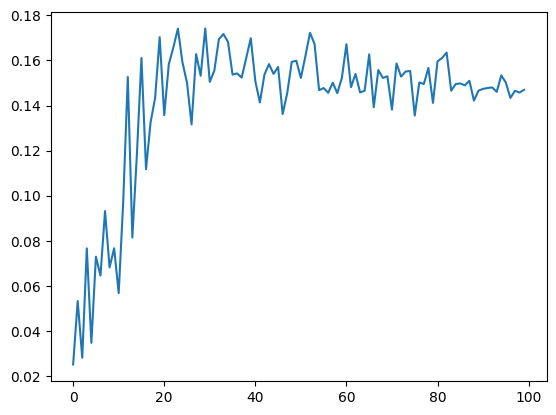

In [23]:
plt.plot(history.history['val_accuracy'])

In [24]:
pred_train=model.predict(X_train)
pred_train_bin= (pred_train > 0.5).astype(int)
print("Training Data:")

print("Accuracy is ",accuracy_score(Y_train,pred_train_bin))
print("Precision is ",precision_score(Y_train,pred_train_bin,average='macro'))
print("Recall is ",recall_score(Y_train,pred_train_bin,average='macro'))
print("F1 Score is ",f1_score(Y_train,pred_train_bin,average='macro'))

pred_val=model.predict(X_cv)
pred_val_bin= (pred_val > 0.5).astype(int)
print("Validation Data:")

print("Accuracy is ",accuracy_score(Y_cv,pred_val_bin))
print("Precision is ",precision_score(Y_cv,pred_val_bin,average='macro'))
print("Recall is ",recall_score(Y_cv,pred_val_bin,average='macro'))
print("F1 Score is ",f1_score(Y_cv,pred_val_bin,average='macro'))


3383/3383 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Training Data:
Accuracy is  0.14405151229606636
Precision is  0.8663086377767367
Recall is  0.0384336408401992
F1 Score is  0.07358883273970976
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Validation Data:
Accuracy is  0.1404578460174048
Precision is  0.8468921455107431
Recall is  0.04219168397660331
F1 Score is  0.08036251306943924


In [25]:

model_best = clone_model(model)

# Important: you need to compile it again
model_best.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Load the best saved weights
model_best.load_weights('best_model.weights.h5')
pred_val=model_best.predict(X_cv)
pred_val_bin= (pred_val > 0.5).astype(int)
pred_train=model_best.predict(X_train)
pred_train_bin= (pred_train> 0.5).astype(int)
print("Training Data:")

print("Accuracy is ",accuracy_score(Y_train,pred_train_bin))
print("Precision is ",precision_score(Y_train,pred_train_bin,average='macro'))
print("Recall is ",recall_score(Y_train,pred_train_bin,average='macro'))
print("F1 Score is ",f1_score(Y_train,pred_train_bin,average='macro'))

print("Validation Data:")

print("Accuracy is ",accuracy_score(Y_cv,pred_val_bin))
print("Precision is ",precision_score(Y_cv,pred_val_bin,average='macro'))
print("Recall is ",recall_score(Y_cv,pred_val_bin,average='macro'))
print("F1 Score is ",f1_score(Y_cv,pred_val_bin,average='macro'))


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1128/1128 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Training Data:
Accuracy is  0.14405151229606636
Precision is  0.8663086377767367
Recall is  0.0384336408401992
F1 Score is  0.07358883273970976
Validation Data:
Accuracy is  0.1404578460174048
Precision is  0.8468921455107431
Recall is  0.04219168397660331
F1 Score is  0.08036251306943924
